In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm, energy_distance
import multiprocessing

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
sys.path.append(".")
from src.dc_smc import dc_smc 
from src.model import Model, LinearGaussian, NonLinearGaussian
from src.utils import resample, effective_sample_size

# Linear Gaussian HMM

In [57]:
# generate data
nsamples = 50 # n_y
T = 10
tf.random.set_seed(0)

# sigma0 = np.array([[1.]])
sigma0 = np.array(1.)
A = np.array([[0.8]])
B = np.ones((1, 1))
C = np.ones((1, 1))
D = np.ones((1, 1))

linear_hmm = LinearGaussian(sigma0, A, B, C, D)
x_vec, y_vec = linear_hmm.sample(nsamples, T)

In [58]:
# SIS
nx = 1000

x_pos = np.zeros((T+1, nx))
log_w = np.zeros_like(x_pos)
x_pos_resampled = np.zeros_like(x_pos)

# t=0
proposal_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1))
x_pos[0, :] = proposal_init.sample(nx)[:, 0]
log_w[0, :] = linear_hmm.log_gamma(x_pos[:1, :], None) - proposal_init.log_prob(x_pos[0, :])
x_pos_resampled[0, :] = resample(log_w[0, :], x_pos[0, :])

# t>=1
for t in range(T):
    # proposal: N(x_{t-1}, 1)
    proposal_t = tfd.Normal(loc=x_pos[t, :], scale=np.ones(1))
    x_pos[t+1, :] = proposal_t.sample(1)
    
    alpha_t = linear_hmm.log_gamma(x_pos[:(t+2), :], y_vec[:(t+1), :]) - \
        linear_hmm.log_gamma(x_pos[:(t+1), :], y_vec[:t, :]) - \
        proposal_t.log_prob(x_pos[t+1, :])
    log_w[t+1, :] = log_w[t, :] + alpha_t
    
    x_pos_resampled[t+1, :] = resample(log_w[t+1, :], x_pos[t+1, :])

    print("true x{}: {} estimate: {}".format(
        t+1, 
        x_vec[t+1, 0], 
        tf.reduce_mean(x_pos_resampled[t+1, :]).numpy()
    ))
    

true x1: 2.2232272715607047 estimate: 2.0194198238800296
true x2: 3.477558810809355 estimate: 3.394570652959467
true x3: 1.6074973498178333 estimate: 1.8315214954282502
true x4: 0.7157036784802129 estimate: 0.31924416522331583
true x5: 1.921818385403494 estimate: 1.331434560057252
true x6: 0.044118388399394526 estimate: 0.5539142400081464
true x7: 0.678292810046603 estimate: 0.6610092158361197
true x8: -0.6627111441898904 estimate: -0.59694124551972
true x9: -2.064314985832259 estimate: -2.722512701259994
true x10: -2.7020150856659293 estimate: -3.371547923705364


true x7: 0.678292810046603 estimate: 0.6610092158361197


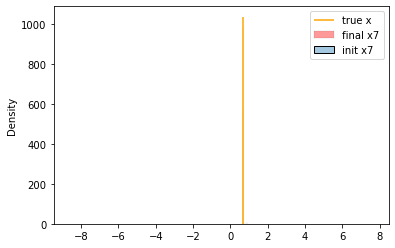

In [65]:
ind = 7

x_true = x_vec[ind, 0]

sns.histplot(x_pos_resampled[ind, :], stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(x_pos[ind, :], stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true, 0, ymax, color="orange", label="true x")
plt.legend()

print(
    f"true x{ind}:", x_true,
    "estimate:", tf.reduce_mean(x_pos_resampled[ind, :]).numpy()
)

## Update likelihood

# Non-linear Gaussian HMM

In [ ]:
# generate data
tf.random.set_seed(0)
nsample = 50
T = 4

sigma0 = np.array([[1.]])
mu0 = np.zeros((1, 1))
sigma_v = np.array([[np.sqrt(10)]])
sigma_w = np.ones((1, 1))

nonlinear_hmm = NonLinearGaussian(sigma0, mu0, sigma_v, sigma_w)
x_vec, y_vec = nonlinear_hmm.sample(nsample, T)

In [ ]:
# SIS
nx = 1000

x_pos = np.zeros((T+1, nx))
log_w = np.zeros_like(x_pos)
x_pos_resampled = np.zeros_like(x_pos)

# t=0
proposal_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1))
x_pos[0, :] = proposal_init.sample(nx)[:, 0]
log_w[0, :] = nonlinear_hmm.log_gamma(x_pos[:1, :], None) - proposal_init.log_prob(x_pos[0, :])
x_pos_resampled[0, :] = resample(log_w[0, :], x_pos[0, :])

# t>=1
for t in range(T):
    # proposal: N(x_{t-1}, 1)
    proposal_t = tfd.Normal(loc=x_pos[t, :], scale=np.ones(1))
    x_pos[t+1, :] = proposal_t.sample(1)
    
    alpha_t = nonlinear_hmm.log_gamma(x_pos[:(t+2), :], y_vec[:(t+1), :]) - \
        nonlinear_hmm.log_gamma(x_pos[:(t+1), :], y_vec[:t, :]) - \
        proposal_t.log_prob(x_pos[t+1, :])
    log_w[t+1, :] = log_w[t, :] + alpha_t
    
    x_pos_resampled[t+1, :] = resample(log_w[t+1, :], x_pos[t+1, :])

    print("true x{}: {} estimate: {}".format(
        t+1, 
        x_vec[t+1, 0], 
        tf.reduce_mean(x_pos_resampled[t+1, :]).numpy()
    ))
    

In [ ]:
ind = 2

x_true = x_vec[ind, 0]

sns.histplot(x_pos_resampled[ind, :], stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(x_pos[ind, :], stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true, 0, ymax, color="orange", label="true x")
plt.legend()

print(
    f"true x{ind}:", x_true,
    "estimate:", tf.reduce_mean(x_pos_resampled[ind, :]).numpy()
)

## Compare with SMC

In [ ]:
# need to change according to model!
def logprior(x):
    T = x.shape[0] - 1
    log_p = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[0, :])
    for i in range(1, T):
        log_p += tfd.Normal(
            loc=nonlinear_hmm._latent_mean(x[i-1, :], i), 
            scale=sigma_v
        ).log_prob(x[i, :])
        print(i, T)
    log_p = tf.reshape(log_p, (-1, 1))
    print("prior", log_p.shape)
    return log_p

def loglik(x):
    T = x.shape[0] - 1
    log_lik = 0
    for t in range(T):
        log_lik += tfd.Normal(
            loc=1/20 * x[t+1, :]**2, 
            scale=sigma_w
        ).log_prob(y_vec[t, :].reshape(-1, 1))
        print(t, T, x.shape)
    log_lik = tf.reshape(tf.reduce_sum(log_lik, axis=0), (-1, 1))
    print("finished")
    print("lik", log_lik.shape)
    return log_lik

def smc(seed, samples_init):
    return tfp.experimental.mcmc.sample_sequential_monte_carlo(
        prior_log_prob_fn=logprior,
        likelihood_log_prob_fn=loglik,
        current_state=samples_init,
        seed=seed)[1]

In [ ]:
x_smc_init = tfd.Normal(loc=np.array(0.), scale=np.array(1.)).sample((T+1, nx))
x_smc_final = smc(1, x_smc_init)

# Hierarchical model

In [ ]:
def sample_y(nsamples, x_vec, eta):
    y_vec = tfd.Normal(loc=x_vec[1:, :], scale=eta).sample(nsamples)
    return y_vec

def hierarchical_targets(y, mu0, sigma0, eta, tau):
    """
        y: n_y x nchildren
        x: nsamples x dim x nchildren
    """
    def log_gamma_leaf(x):
        log_lik = tfd.Normal(loc=x[:, :, 1:], scale=eta).log_prob(y)
        log_lik = tf.reduce_sum(log_lik, axis=1, keepdims=True)
        
        x0 = x[:, :, 0][:, :, np.newaxis]
        log_p = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x0)
        log_p += tfd.Normal(loc=x0, scale=tau).log_prob(x[:, :, 1:])
        
        res = tf.reduce_sum(log_p + log_lik, axis=-1, keepdims=True)
        return res
    
    def log_gamma_root(x):
        x0 = x[:, :, 0][:, :, np.newaxis]
        log_p = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x0)
        return log_p
    
    return log_gamma_leaf, log_gamma_root
    
# def sample_x(nsamples, mu0, sigma0, tau):
#     x_vec = np.zeros((nsapmles, 5))
#     x_vec[:, 0] = tfd.Normal(loc=mu0, scale=sigma0).sample(nsamples)
#     x_vec[:, 1:] = tfd.Normal(loc=x_vec[:, 0], scale=tau).sample((nsamples, x_vec.shape[1]-1))
#     return x_vec


In [ ]:
class Proposal:
    def __init__(self):
        self.dist = tfd.Normal(np.zeros(1), np.ones(1))
    def log_prob(self, mu_new, mu_curr):
        log_p = self.dist.log_prob(mu_new) # nsample x dim
        return tf.reduce_sum(log_p, axis=-1, keepdims=True)
    def sample(self, size, mu_curr):
        return self.dist.sample(size)[:, :, :, 0]

In [ ]:
# sample data
tf.random.set_seed(0)

sigma0 = np.ones((1, 1))
eta = np.ones((1, 1))
tau = np.ones((1, 1))

nchildren = 4
nsample = 500 # n_y
nx = 1000 

x_vec = np.ones((1, 1, nchildren + 1))
x_vec[:, :, 1:] = tf.reshape(
    tfd.Normal(loc=x_vec[:, :, 0], scale=np.array(1.)).sample(nchildren),
    (1, -1)
)
y_vec = tfd.Normal(loc=x_vec[:, :, 1:], scale=eta).sample(nsample)[:, 0, 0, :]
assert y_vec.shape[-1] == nchildren, f"shape of y_vec is wrong! Got {y_vec.shape}"

proposal = Proposal()
log_gamma_leaf, log_gamma_root = hierarchical_targets(y_vec, mu0, sigma0, eta, tau)

In [ ]:
# model = Model(log_gamma_root, proposal, 0)
# for i in range(nchildren):
#     model.build_child(log_gamma_leaf, proposal, i)

In [ ]:
# draw from proposal
x_pos = proposal.sample((nx, 1, nchildren + 1), None)
# compute IS weights
log_w = log_gamma_leaf(x_pos) - proposal.log_prob(x_pos, None)
# resample (for plotting)
x_pos_resampled = resample(log_w, x_pos)

In [ ]:
sns.histplot(log_w[:, 0, 0])

In [ ]:
ind = 3

x_true = x_vec[0, :, ind]

sns.histplot(x_pos_resampled[:, 0, ind], stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(x_pos[:, 0, ind], stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true, 0, ymax, color="orange", label="true x")
plt.legend()

print(
    f"true x{ind}:", x_true,
    "estimate:", tf.reduce_mean(x_pos_resampled[ind, :]).numpy()
)

## Change likelihood

In [ ]:
def hierarchical_targets_new(y, mu0, sigma0, eta, tau):
    """
        y: n_y x nchildren
        x: nsamples x dim x nchildren
    """
    def log_gamma_leaf(x):
        log_lik = tfd.Normal(loc=x[:, :, 2:], scale=eta).log_prob(y[:, 1:])
        log_lik1 = tfd.Normal(loc=x[:, :, 1:2], scale=eta*2).log_prob(y[:, :1])
        log_lik = tf.concat([log_lik1, log_lik], axis=-1)
        log_lik = tf.reduce_sum(log_lik, axis=1, keepdims=True)
        
        x0 = x[:, :, 0][:, :, np.newaxis]
        log_p = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x0)
        log_p += tfd.Normal(loc=x0, scale=tau).log_prob(x[:, :, 1:])
        
        res = tf.reduce_sum(log_p + log_lik, axis=-1, keepdims=True)
        return res
    
    def log_gamma_root(x):
        x0 = x[:, :, 0][:, :, np.newaxis]
        log_p = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x0)
        return log_p
    
    return log_gamma_leaf, log_gamma_root

In [ ]:
proposal = Proposal()
log_gamma_leaf_new, log_gamma_root_new = hierarchical_targets_new(y_vec, mu0, sigma0, eta, tau)

In [ ]:
# start from previous step
x_pos_new = x_pos_resampled
# compute IS weights
log_w_new = log_gamma_leaf_new(x_pos_new) - log_gamma_leaf(x_pos_new)
# resample (for plotting)
x_pos_resampled_new = resample(log_w_new, x_pos_new)

In [ ]:
ind = 1

x_true = x_vec[0, :, ind]

sns.histplot(x_pos_resampled_new[:, 0, ind], stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(x_pos_new[:, 0, ind], stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true, 0, ymax, color="orange", label="true x")
plt.legend()

print(
    f"true x{ind}:", x_true,
    "estimate:", tf.reduce_mean(x_pos_resampled[ind, :]).numpy()
)

# Tempering

1D Normal model: 

Prior: $x \sim N(\mu_0, \sigma_0^2)$

$y | x \sim N(x, 1)$

In [2]:
# define log_prob for the unnormalized posterior
def log_prior(x):
    p = tfd.Normal(mu0, sigma0)
    return p.log_prob(x)

def sample_prior(size):
    """
    Output: size x 1
    """
    p = tfd.Normal(mu0, sigma0)
    return p.sample(size)[:, :, 0]

def log_pos(x, y, sigma, log_prior):
    '''
    Args:
        mu: 1 x nsamples
        y: ndata
    Output:
        log_prob: 1 x nsamples
    '''
    rv_data = tfd.Normal(x, sigma)
    logp = log_prior(x)
    tf.reduce_sum(rv_data.log_prob(y), axis=0)
    return tf.reduce_sum(rv_data.log_prob(y), axis=0) + log_prior(x)

def true_log_pos(x, y, sigma, mu0, sigma0):
    '''True posterior density
    '''
    true_pos_var = (1 / sigma0**2 + y.shape[0] / sigma**2)**(-1)
    true_pos_mean = true_pos_var * (mu0 / sigma0**2 + np.sum(y) / sigma**2)
    pos = tfd.Normal(loc=true_pos_mean, scale=np.sqrt(true_pos_var))
    return pos.log_prob(x)

def tempered_den_wrapper(kappa, log_pos):
    def den(x):
        return kappa * log_pos(x)
    return den

class Proposal:
    def __init__(self):
        pass
    def log_prob(self, mu_new, mu_curr):
        self.dist = tfd.Normal(mu_curr, tf.ones(1))
        log_p = self.dist.log_prob(mu_new) # nsample x dim
        return tf.reduce_sum(log_p, axis=-1, keepdims=True)
    def sample(self, mu_curr):
        self.dist = tfd.Normal(mu_curr, tf.ones(1))
        return self.dist.sample(1)[0, :, :] # nsample x dim

In [3]:
tf.random.set_seed(0)

mu0 = tf.constant([[0.]])
sigma0 = tf.constant([[1.]])
sigma = tf.constant([[1.]])
x_true = tf.constant([[3.]])

nobs = 10
nsamples = 1000

y_vec = tfd.Normal(x_true, sigma).sample(nobs)

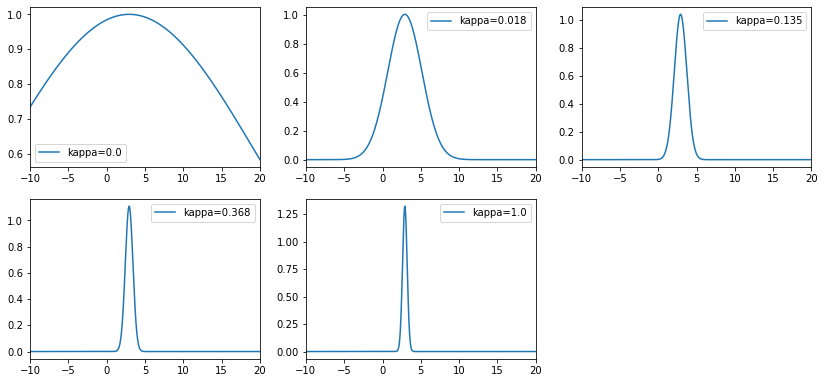

In [4]:
## plot annealed densities

kappa_list = np.exp([-8, -4, -2, -1, 0])
x_plot = np.linspace(-10., 20., 1000).reshape((-1, 1))

# use true posterior for plotting
log_pos_dummy = lambda x: true_log_pos(x, y_vec, sigma, mu0, sigma0)

fig = plt.figure(figsize=(14, 10))
for i, kappa in enumerate(kappa_list):
    plt.subplot(3, 3, i+1)
    tempered_den = tempered_den_wrapper(kappa, log_pos_dummy)
    plt.plot(x_plot, np.exp(tempered_den(x_plot)), label=f"kappa={np.round(kappa, 3)}")
    plt.xlim(-10, 20)
    plt.legend()

In [5]:
# importance sampling
def importance_sampling(kappa_list, init_samples, log_prior, log_pos_dummy, proposal):
    # set list to store particles
    x_proposal_list = [0] * len(kappa_list)
    x_resampled_list = [0] * len(kappa_list)
    log_w_list = [0] * len(kappa_list)

    for i, kappa in enumerate(kappa_list):
        # draw from proposal
        if i == 0:
            x_proposal = init_samples
            log_den_before = log_prior
        else:
            if proposal:
                x_proposal = proposal.sample(x_resampled)
                log_den_before = lambda x: proposal.log_prob(x, x_resampled)
                print("here", tf.reduce_min(x_proposal))
            else:
                x_proposal = x_resampled
                log_den_before = tempered_den
        
        # initialize tempered density
        tempered_den = tempered_den_wrapper(kappa, log_pos_dummy)

        # compute IS weights
        log_w = tempered_den(x_proposal) - log_den_before(x_proposal)

        # resample
        x_resampled = resample(log_w, x_proposal)

        # store particles and weights
        x_proposal_list[i] = x_proposal
        x_resampled_list[i] = x_resampled
        log_w_list[i] = log_w
    return x_proposal_list, x_resampled_list, log_w_list


def plot_IS_results(kappa_list, x_resampled_list, x_proposal_list, x_true,
                   label1="final x", label2="init x"):
    # not show initial samples if not specified
    if x_proposal_list is None:
        x_proposal_list = [[False]] * len(x_resampled_list)
    
    fig = plt.figure(figsize=(14, 10))
    for i, kappa in enumerate(kappa_list):
        x_resampled = x_resampled_list[i]
        x_proposal = x_proposal_list[i]

        plt.subplot(3, 3, i+1)
        sns.histplot(x_resampled[:, 0], stat="density", color="r", alpha=0.4, label=label1)
        if any(x_proposal):
            sns.histplot(x_proposal[:, 0], stat="density", alpha=0.4, label=label2)
        ymax = plt.ylim()[1]
        plt.vlines(x_true, 0, ymax, color="orange", label="true x")
        plt.legend()
        plt.title("kappa = {:.3g}".format(kappa))
        
        print("kappa: {:.3g}, true: {:.3g}, estimate: {:.3g}, MSE: {:.3g}".format(
            kappa,
            x_true[0, 0],
            tf.reduce_mean(x_resampled).numpy(),
            (tf.reduce_mean(x_resampled).numpy() - x_true[0, 0])**2
        ))

# Sample sequentially from tempered distributions

In [6]:
## do IS for posterior

# initialize target density
log_pos_dummy = lambda x: log_pos(x, y_vec, sigma, log_prior)

# # set proposal
# proposal = Proposal()
proposal = None

# draw initial sample
x_init = sample_prior(nsamples)

# set annealing temperature
# kappa_list = np.exp([-32, -16, -8, -4, -2, -1, 0])
kappa_list = np.exp([-8, -4, -2, -1, 0])
# kappa_list = np.exp([0] * 1)

x_proposal_list, x_resampled_list, log_w_list = importance_sampling(
    kappa_list, x_init, log_prior, log_pos_dummy, proposal)

kappa: 0.000335, true: 3, estimate: 0.0985, MSE: 8.42
kappa: 0.0183, true: 3, estimate: 1.67, MSE: 1.77
kappa: 0.135, true: 3, estimate: 2.54, MSE: 0.209
kappa: 0.368, true: 3, estimate: 2.7, MSE: 0.0914
kappa: 1, true: 3, estimate: 2.79, MSE: 0.046


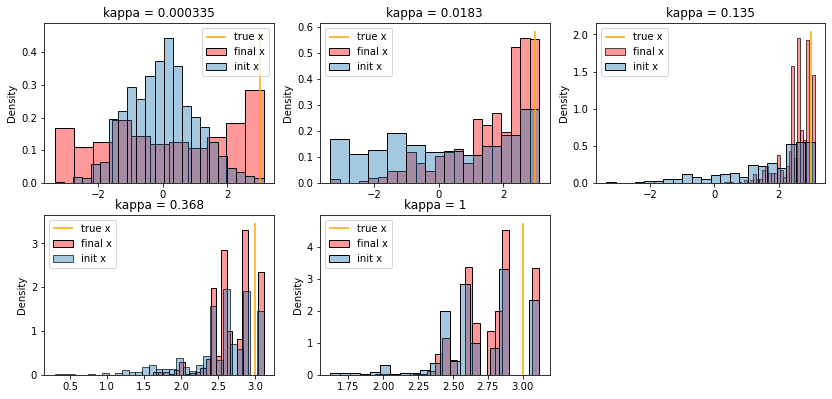

In [7]:
plot_IS_results(kappa_list, x_resampled_list, x_proposal_list, x_true)

Text(0, 0.5, 'ESS')

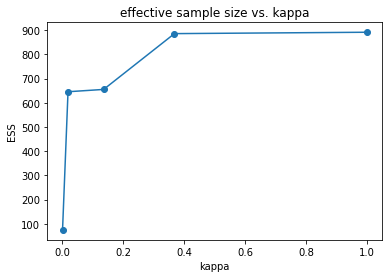

In [8]:
# calculate ESS
ess_list = [
    effective_sample_size(w) for w in log_w_list
]
plt.plot(kappa_list, ess_list, marker="o")
plt.title("effective sample size vs. kappa")
plt.xlabel("kappa")
plt.ylabel("ESS")

In [9]:
def run_hmc(kappa_list, log_pos_dummy, num_results=None):
    samples_list = [0] * len(kappa_list)
    num_results = nsamples if num_results is None else num_results
    num_burnin_steps = 1000
    
    @tf.function()
    def run_chain(adaptive_hmc):
        # Run the chain (with burn-in).
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=0.,
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

        is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
        return samples, is_accepted
    
    for i, kappa in enumerate(kappa_list):
        print("Running HMC for kappa = {:.3g}".format(kappa))
        
        tempered_den = tempered_den_wrapper(kappa, log_pos_dummy)
        def test_log_prob(x):
            res = tempered_den(x)
            res = res[0, 0] if res.shape == (1, 1) else res
            return res

        # Initialize the HMC transition kernel.
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
            tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=test_log_prob,
                num_leapfrog_steps=3,
                step_size=1.),
            num_adaptation_steps=int(num_burnin_steps * 0.8))

        # Run the chain (with burn-in).
        res = run_chain(adaptive_hmc)
        samples_list[i] = tf.reshape(res[0], (-1, 1))
        
    return samples_list


In [10]:
def plot_IS_results_single(kappa, x_resampled, x_proposal, x_true):
    x_proposal = [[False]] if x_proposal is None else x_proposal
    
    sns.histplot(x_resampled[:, 0], stat="density", color="r", alpha=0.4, label="final x")
    if any(x_proposal):
        sns.histplot(x_proposal[:, 0], stat="density", alpha=0.2, label="init x")
    ymax = plt.ylim()[1]
    plt.vlines(x_true, 0, ymax, color="orange", label="true x")
    plt.legend()
    plt.title(f"kappa = {np.round(kappa, 3)}")

    print("kappa: {:.3g}, true: {:.3g}, estimate: {:.3g}, MSE: {:.3g}".format(
        kappa,
        x_true[0, 0],
        tf.reduce_mean(x_resampled).numpy(),
        (tf.reduce_mean(x_resampled).numpy() - x_true[0, 0])**2
    ))
    

def run_IS_experiment(starting_kappas, log_pos_dummy_new, log_pos_dummy_old, proposal, x_init, x_true,
                     sampling_kappas=None):
    ## do IS for tempered density
    # set list to store particles
    x_proposal_list_new = [0] * len(kappa_list)
    x_resampled_list_new = [0] * len(kappa_list)
    log_w_list_new = [0] * len(kappa_list)
    
    kappa_sample = [1.] if sampling_kappas is None else sampling_kappas # kappa for single IS step

    fig = plt.figure(figsize=(14, 10))
    for i, kappa in enumerate(starting_kappas):
        # set new starting density (i.e. target of previous step)
        #! need to change this if proposal dist is used!
        if proposal:
            log_p_init_new = lambda x: proposal.log_prob(x, tf.zeros(x.shape))
        else:
            log_p_init_new = tempered_den_wrapper(
                kappa, log_pos_dummy_old)

        # set initial samples as samples from target of previous step
        x_init_samples = x_init[i]

        x_proposal_new, x_resampled_new, log_w_new = importance_sampling(
            kappa_sample, x_init_samples, log_p_init_new, log_pos_dummy_new, proposal)

        # store results
        x_resampled_new = x_resampled_new[0]
        x_proposal_new = x_proposal_new[0]
        log_w_new = log_w_new[0]
        
        x_resampled_list_new[i] = x_resampled_new
        x_proposal_list_new[i] = x_proposal_new
        log_w_list_new[i] = log_w_new
        
        # plot results
        plt.subplot(3, 3, i+1)
        plot_IS_results_single(kappa, x_resampled_new, x_proposal_new, x_true)
        
    return x_proposal_list_new, x_resampled_list_new, log_w_list_new
    

def plot_effective_sample_size(kappa_list, log_w_list):
    # calculate ESS
    ess_list = [
        effective_sample_size(w) for w in log_w_list
    ]
    plt.plot(kappa_list, ess_list, marker="o")
    plt.title("effective sample size vs. kappa")
    plt.xlabel("kappa")
    plt.ylabel("ESS")
    
    return ess_list

def plot_energy_distance(kappa_list, x_approx, x_true):
    # calculate ESS
    dist_list = [
        energy_distance(tf.reshape(x, (-1)), tf.reshape(y, (-1))) for x, y in zip(x_approx, x_true)
    ]
    plt.plot(kappa_list, dist_list, marker="o")
    plt.title("energy distance vs. kappa")
    plt.xlabel("kappa")
    plt.ylabel("energy distance")
    
    return dist_list
    

## Inclusion of additional data

In [11]:
# draw more samples
y_vec_new = tf.concat(
        [y_vec, tfd.Normal(x_true, sigma).sample(nobs)],
    axis=0)

# initialize new target density
log_pos_dummy_new = lambda x: log_pos(x, y_vec_new, sigma, log_prior)

# set proposal 
proposal = None

In [12]:
# draw "true" samples from tempered distributions
hmc_samples = run_hmc(kappa_list, log_pos_dummy)

Running HMC for kappa = 0.000335
Running HMC for kappa = 0.0183
Running HMC for kappa = 0.135
Running HMC for kappa = 0.368
Running HMC for kappa = 1


kappa: 0.000335, true: 3, estimate: 2.78, MSE: 0.0504
kappa: 0.0183, true: 3, estimate: 2.81, MSE: 0.0345
kappa: 0.135, true: 3, estimate: 2.8, MSE: 0.0405
kappa: 0.368, true: 3, estimate: 2.8, MSE: 0.0406
kappa: 1, true: 3, estimate: 2.76, MSE: 0.0581


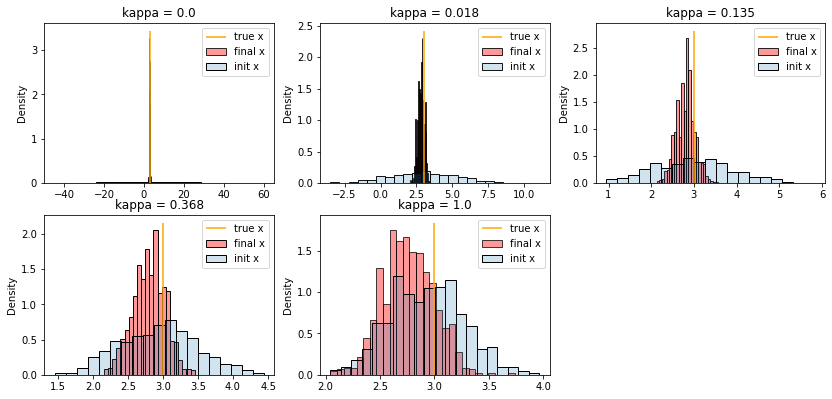

In [13]:
x_proposal_list_new, x_resampled_list_new, log_w_list_new = run_IS_experiment(
    kappa_list, 
    log_pos_dummy_new=log_pos_dummy_new, 
    log_pos_dummy_old=log_pos_dummy, 
    proposal=proposal,
    x_init=hmc_samples,
    x_true=x_true)

Running HMC for kappa = 1
kappa: 0.000335, true: 3, estimate: 2.78, MSE: 0.0504
kappa: 0.0183, true: 3, estimate: 2.81, MSE: 0.0345
kappa: 0.135, true: 3, estimate: 2.8, MSE: 0.0405
kappa: 0.368, true: 3, estimate: 2.8, MSE: 0.0406
kappa: 1, true: 3, estimate: 2.76, MSE: 0.0581


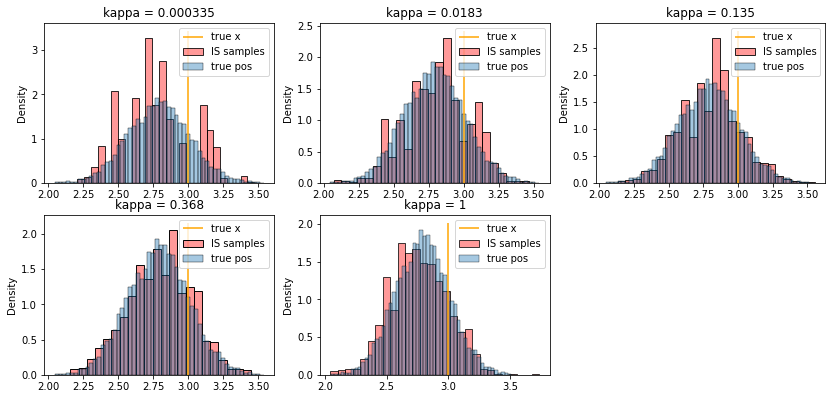

In [14]:
# draw "true" samples from new target
hmc_samples_new = run_hmc([1.], log_pos_dummy_new, num_results=10000)
# compare with IS samples
plot_IS_results(kappa_list, x_resampled_list_new, hmc_samples_new*len(kappa_list), x_true,
               label1="IS samples", label2="true pos")

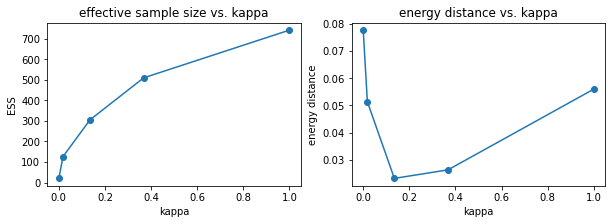

In [15]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
ess_list = plot_effective_sample_size(kappa_list, log_w_list_new)
plt.subplot(1, 2, 2)
dist_list = plot_energy_distance(kappa_list, x_resampled_list_new, hmc_samples_new*len(kappa_list))

## Change in prior

In [16]:
# sigma0_new = sigma0 * 0.5
sigma0_new = sigma0 * 2

def log_prior_new(x):
    p = tfd.Normal(mu0, sigma0_new)
    return p.log_prob(x)

# set target density
log_pos_dummy_new = lambda x: log_pos(x, y_vec, sigma, log_prior_new)

# set proposal
# proposal = Proposal()
proposal = None

kappa: 0.000335, true: 3, estimate: 3.07, MSE: 0.00428
kappa: 0.0183, true: 3, estimate: 3.13, MSE: 0.0177
kappa: 0.135, true: 3, estimate: 3.16, MSE: 0.0254
kappa: 0.368, true: 3, estimate: 3.16, MSE: 0.027
kappa: 1, true: 3, estimate: 3.19, MSE: 0.0366


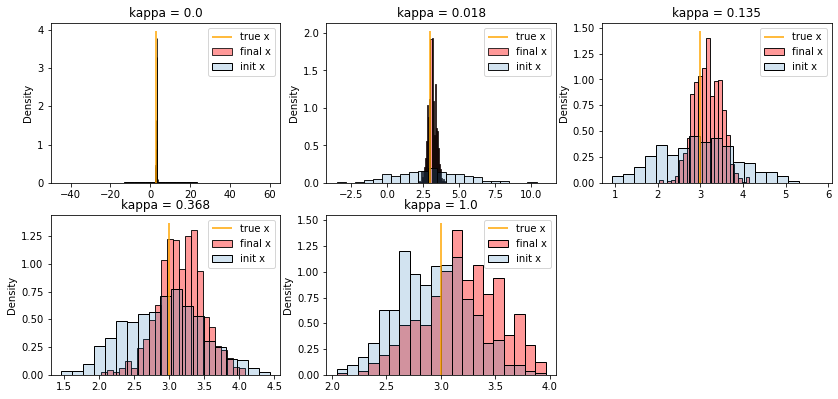

In [17]:
x_proposal_list_new, x_resampled_list_new, log_w_list_new = run_IS_experiment(
    kappa_list, 
    log_pos_dummy_new=log_pos_dummy_new, 
    log_pos_dummy_old=log_pos_dummy, 
    proposal=proposal,
    x_init=hmc_samples,
    x_true=x_true)

Running HMC for kappa = 1
kappa: 0.000335, true: 3, estimate: 3.07, MSE: 0.00428
kappa: 0.0183, true: 3, estimate: 3.13, MSE: 0.0177
kappa: 0.135, true: 3, estimate: 3.16, MSE: 0.0254
kappa: 0.368, true: 3, estimate: 3.16, MSE: 0.027
kappa: 1, true: 3, estimate: 3.19, MSE: 0.0366


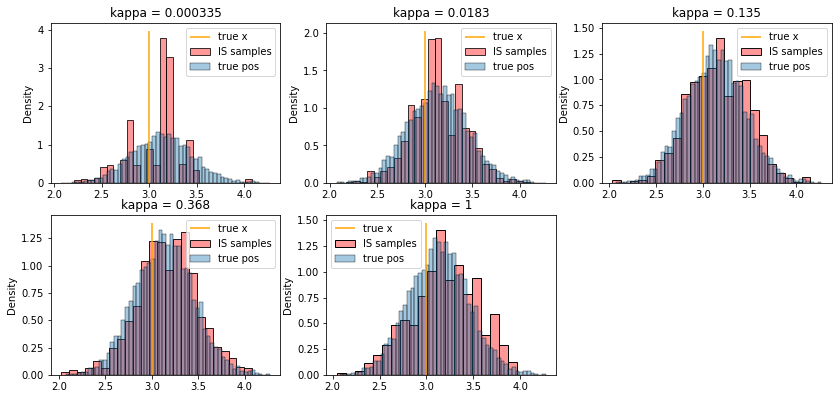

In [18]:
# draw "true" samples from new target
hmc_samples_new = run_hmc([1.], log_pos_dummy_new, num_results=10000)
# compare with IS samples
plot_IS_results(kappa_list, x_resampled_list_new, hmc_samples_new*len(kappa_list), x_true,
               label1="IS samples", label2="true pos")

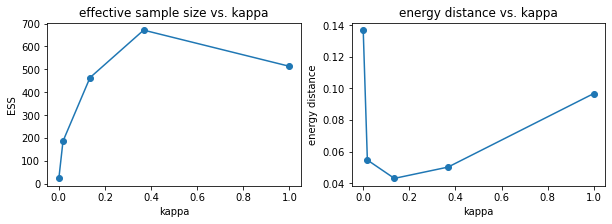

In [19]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
ess_list = plot_effective_sample_size(kappa_list, log_w_list_new)
plt.subplot(1, 2, 2)
dist_list = plot_energy_distance(kappa_list, x_resampled_list_new, hmc_samples_new*len(kappa_list))

## Change in x_true

In [20]:
# assume there is a change in x_true
x_true_new = tf.constant([[-2.]])

y_vec_new = tfd.Normal(x_true_new, sigma).sample(nobs)

# initialize new target density
log_pos_dummy_new = lambda x: log_pos(x, y_vec_new, sigma, log_prior)

# set proposal 
proposal = None

kappa: 0.000335, true: -2, estimate: -1.83, MSE: 0.0295
kappa: 0.0183, true: -2, estimate: -1.61, MSE: 0.15
kappa: 0.135, true: -2, estimate: 0.967, MSE: 8.8
kappa: 0.368, true: -2, estimate: 1.46, MSE: 12
kappa: 1, true: -2, estimate: 2.05, MSE: 16.4


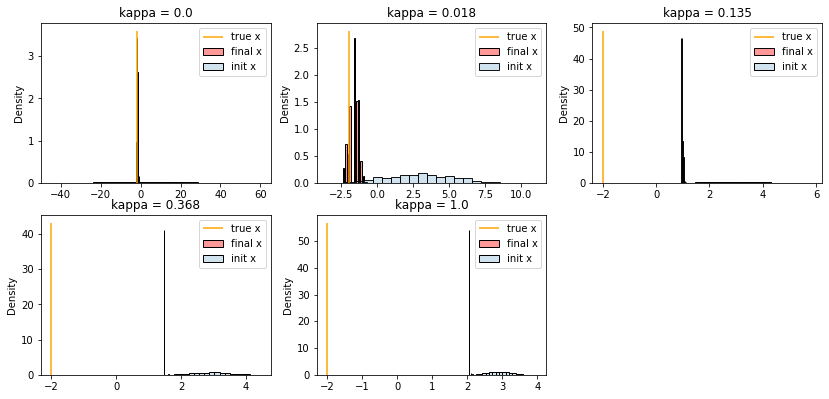

In [21]:
x_proposal_list_new, x_resampled_list_new, log_w_list_new = run_IS_experiment(
    kappa_list, 
    log_pos_dummy_new=log_pos_dummy_new, 
    log_pos_dummy_old=log_pos_dummy, 
    proposal=proposal,
    x_init=hmc_samples,
    x_true=x_true_new)

Running HMC for kappa = 1
kappa: 0.000335, true: -2, estimate: -1.83, MSE: 0.0295
kappa: 0.0183, true: -2, estimate: -1.61, MSE: 0.15
kappa: 0.135, true: -2, estimate: 0.967, MSE: 8.8
kappa: 0.368, true: -2, estimate: 1.46, MSE: 12
kappa: 1, true: -2, estimate: 2.05, MSE: 16.4


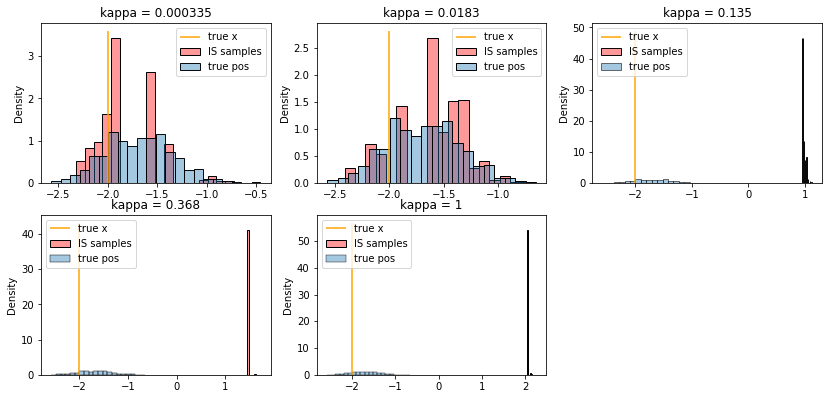

In [22]:
# draw "true" samples from new target
hmc_samples_new = run_hmc([1.], log_pos_dummy_new)
# compare with IS samples
plot_IS_results(kappa_list, x_resampled_list_new, hmc_samples_new*len(kappa_list), x_true_new,
               label1="IS samples", label2="true pos")

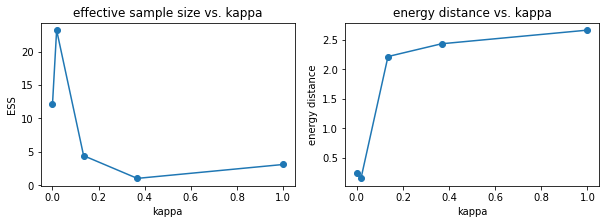

In [23]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
ess_list = plot_effective_sample_size(kappa_list, log_w_list_new)
plt.subplot(1, 2, 2)
dist_list = plot_energy_distance(kappa_list, x_resampled_list_new, hmc_samples_new*len(kappa_list))

## Change in data generating process

In [24]:
# set new likelihood param
# sigma_new = sigma * 0.5
sigma_new = sigma * 2

y_vec_new = tfd.Normal(x_true, sigma_new).sample(nobs)

# set target density
log_pos_dummy_new = lambda x: log_pos(x, y_vec_new, sigma_new, log_prior)

# set proposal
# proposal = Proposal()
proposal = None

# set annealing temperature
# kappa_list = np.exp([-2,  -0.1, -0.01, 0])
kappa_list_new = np.exp([0] * 1)

kappa: 0.000335, true: 3, estimate: 2.23, MSE: 0.598
kappa: 0.0183, true: 3, estimate: 2.14, MSE: 0.739
kappa: 0.135, true: 3, estimate: 2.06, MSE: 0.886
kappa: 0.368, true: 3, estimate: 2.19, MSE: 0.656
kappa: 1, true: 3, estimate: 2.43, MSE: 0.33


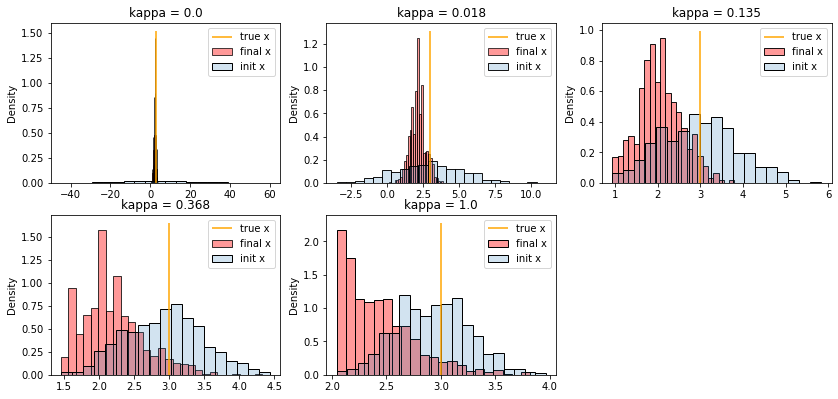

In [25]:
x_proposal_list_new, x_resampled_list_new, log_w_list_new = run_IS_experiment(
    kappa_list, 
    log_pos_dummy_new=log_pos_dummy_new, 
    log_pos_dummy_old=log_pos_dummy, 
    proposal=proposal,
    x_init=hmc_samples,
    x_true=x_true)

Running HMC for kappa = 1
kappa: 0.000335, true: 3, estimate: 2.23, MSE: 0.598
kappa: 0.0183, true: 3, estimate: 2.14, MSE: 0.739
kappa: 0.135, true: 3, estimate: 2.06, MSE: 0.886
kappa: 0.368, true: 3, estimate: 2.19, MSE: 0.656
kappa: 1, true: 3, estimate: 2.43, MSE: 0.33


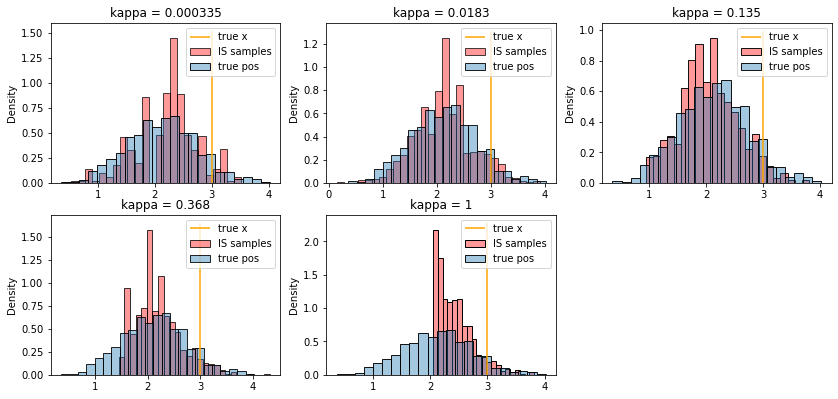

In [26]:
# draw "true" samples from new target
hmc_samples_new = run_hmc([1.], log_pos_dummy_new)
# compare with IS samples
plot_IS_results(kappa_list, x_resampled_list_new, hmc_samples_new*len(kappa_list), x_true,
               label1="IS samples", label2="true pos")

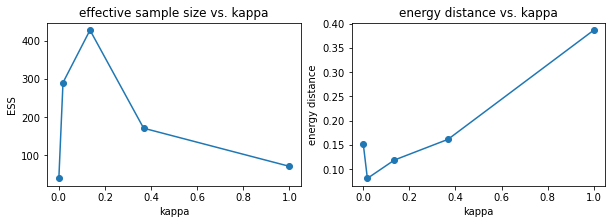

In [27]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
ess_list = plot_effective_sample_size(kappa_list, log_w_list_new)
plt.subplot(1, 2, 2)
dist_list = plot_energy_distance(kappa_list, x_resampled_list_new, hmc_samples_new*len(kappa_list))